# Machine Learning with PyTorch

PyTorch is a popular machine learning library. Its main competitor in this area
is Tensorflow/Keras. PyTorch tends to follow a more low-level pythonic approach
making it easier to integrate your own Python code into customized
network layers; however, both allow for modular model building and easy 
transition to GPU computing. 

&star; PyTorch was started as a Python implementation of the original Torch project 
which used Lua and is no longer in active development. Confusingly,
the Python package for PyTorch is called 'torch', not pytorch....


## Installation

The PyTorch website lets you choose your installation options and shows the
corresponding pip statement: 

https://pytorch.org/

We use the CPU-only version here; the download is *much* smaller, and it will run
on any hardware. 

#### Optional: GPU Support with CUDA (NVIDIA) and ROCm (AMD)

The CUDA/ROCm version of Pytorch only makes 
sense if (1) you have a supported graphics card, and (2) you actually need the 
increased performance. GPU computing may work out of the box for you, or it
may turn into a major headache. 
Supported GPUs used to mean NVIDIA only,
but recently AMD has joined with their ROCm cards. Even integrated
graphics can be made to work [13], of course with moderate performance gains. 

What kind of speedup can be achieved with GPU computing in 
machine learning? 
It depends *very much* on the application. Note that

- transfer to and from card memory is slow; make sure all your training data 
  fits into memory on the graphics card.
- GPUs are built for massive parallel processing. Suitable applications make
  use of this, e.g. matrix multiplication or other array computing that can
  easily be done in parallel. Connectionist approaches usually rely heavily
  on this type of processing.

Anecdotal evidence: several years ago this author
purchased a mid-range graphics card and achieved an average speedup 
of about 5x compared to CPU on some small Python ML projects. 
Compare with e.g. more recent [12] where similiar speedups are 
achieved with mid-range hardware.

The PyTorch website has a nice example showing how to use the GPU device: 

https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html




In [7]:
# Linux
# pip install torch --index-url https://download.pytorch.org/whl/cpu

Check installation and print version -- software keeps changing, if your version
is too old (or too new!) the code in this notebook may not work.

In [8]:
import torch
print(torch.__version__)

# for CUDA/ROCm installation:
# print(torch.cuda.get_device_properties(0)) 

2.0.1+cpu


## Optimizing a Polynomial Model

We start with a very simple model,
a polynomial [1, 2]:

    f(x) = a + b * x + c * x**2 + d * x**3

With suitable values for a,b,c,d we can approximate data points, such as these [3]:

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 7  5  7  7  5  6  3  5  7  8 14 13 12  9  4  7  8 16 23 23]


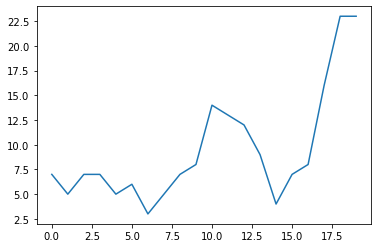

In [9]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=4, threshold=50)
np.random.seed(13)
y = np.array([7, 5, 7, 7, 5, 6, 3, 5, 7, 8, 14, 13, 12, 9, 4, 7, 8, 16, 23, 23])
x = np.arange(20)
print(x)
print(y)
plt.plot(x, y)
plt.show()

Let us guess some coefficient values and see how they work. We also define an error 
function to evaluate to solution numerically; the sum of squares is a common choice.

y: [ 7  5  7  7  5  6  3  5  7  8 14 13 12  9  4  7  8 16 23 23]
y_: [ 8.     8.012  7.696  7.124  6.368  5.5    4.592  3.716  2.944  2.348
  2.     1.972  2.336  3.164  4.528  6.5    9.152 12.556 16.784 21.908]
err: 25.594472000000003


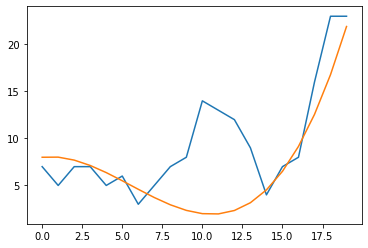

In [10]:
c = np.array([ 8, 0.2, -0.2, 0.012 ])

def f(x, c): return sum([ c[i] * pow(x, i) for i in range(len(c)) ]) 
def err(y, y_): return sum((y-y_)**2)/len(y)

y_ = f(x,c) 
print('y:', y)
print('y_:', y_)
print('err:', err(y, y_))
plt.plot(y)
plt.plot(y_)
plt.show()

In all but the most trivial cases guessing is not a good strategy. We 
let Torch optimize the coefficients to minimize the 
error. 

&starf; Sadly, we have to convert our Python lists and Numpy arrays into torch.tensors for 
PyTorch to create the computation graph and the gradients. However, they are not as
convenient as Numpy arrays, so we convert them
back to Numpy for further processing, or even just nice printing.
This is probably the biggest downside of using PyTorch.

Tensors are created with
- torch.tensor() which always copies the data, while 
- torch.as_tensor() avoids copying if  possible, such as for Numpy arrays. 

In [11]:
import torch as t
t.manual_seed(11)

c_ = t.tensor(c, requires_grad=True) 
x = t.tensor(x)
y = t.tensor(y)
opti = t.optim.Adam((c_,), lr=0.2)
for ep in range(1000):
    y_ = f(x, c_)
    loss = err(y, y_) 
    if (ep % 100) == 0: print("ep: %4d  loss: %12.2f" % (ep, loss.item()))
    opti.zero_grad()
    loss.backward()
    opti.step()
print('y_:', y_)
print('loss:', loss)
print('\ncoefficients, original and optimized:')
print(np.vstack((c, c_.detach().numpy())))

ep:    0  loss:        25.59
ep:  100  loss:        24.15
ep:  200  loss:        12.80
ep:  300  loss:        12.54
ep:  400  loss:        12.34
ep:  500  loss:        12.16
ep:  600  loss:        12.01
ep:  700  loss:        11.90
ep:  800  loss:        11.81
ep:  900  loss:        11.74
y_: tensor([ 6.6148,  6.8946,  7.0234,  7.0378,  6.9748,  6.8711,  6.7635,  6.6889,
         6.6840,  6.7856,  7.0306,  7.4558,  8.0979,  8.9937, 10.1802, 11.6940,
        13.5720, 15.8509, 18.5677, 21.7590], dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss: tensor(11.7005, dtype=torch.float64, grad_fn=<DivBackward0>)

coefficients, original and optimized:
[[ 8.      0.2    -0.2     0.012 ]
 [ 6.6134  0.3677 -0.0939  0.0061]]


The example above shows all the essential elements of the pytorch approach:

- The requires_grad option starts the computation graph. Everything
derived from this tensor becomes part of the graph and is used in 
the automatic construction of the gradient. 
  - y_ is a tensor because it is computed from tensors
  - its gradient function
  is Add because this was the last operation in function f()
  - loss was computed by err() with last operation Div

- The Adam optimizer (Adaptive Moment Estimation) uses a decaying average 
of past gradient values and an adaptive learning rate. As a rule of thumb, this 
optimizer tends to be solid choice.

- The optimizer needs to know the list of parameters, often as model.parameters();
here we provide the tupel directly.

- The zero_grad() call is somewhat counter-intuitive; without it, the gradients
are accumulated (which we do not want here).

- loss.backward() computes the gradient values back along the computation graph 

- opti.step() lets the optimizer calculate the parameter updates

#### &star; Optional: Show the computation graph

This only makes sense for very small examples, even our polynomial results
in a pretty big picture. Compare with the operations in the code above.

In [12]:
print(y_.grad_fn)
print(y_.grad_fn.next_functions)

# torchviz is a very small package, but you also need to   apt-get install graphviz
# !python3 -m pip install torchviz 

from torchviz import make_dot

make_dot(loss).render(format='png')

((<AddBackward0 object at 0x7ff5d382fd90>, 0), (<MulBackward0 object at 0x7ff5d382fcd0>, 0))


'Digraph.gv.png'

<img src="Digraph.gv.png">

In [13]:
def shownode(x):
    if hasattr(x, 'next_functions'):
        for f in x.next_functions:
            if f[0] is not None:
                print(f)
                shownode(f[0])
                
shownode(y_.grad_fn)

(<AddBackward0 object at 0x7ff5d39dc790>, 0)
(<AddBackward0 object at 0x7ff5d39de680>, 0)
(<AddBackward0 object at 0x7ff5d39de5c0>, 0)
(<MulBackward0 object at 0x7ff5d39de560>, 0)
(<SelectBackward0 object at 0x7ff5d39dc3d0>, 0)
(<AccumulateGrad object at 0x7ff5d39dc430>, 0)
(<MulBackward0 object at 0x7ff5d39de620>, 0)
(<SelectBackward0 object at 0x7ff5d39dc4c0>, 0)
(<AccumulateGrad object at 0x7ff5d39dc430>, 0)
(<MulBackward0 object at 0x7ff5d39dc700>, 0)
(<SelectBackward0 object at 0x7ff5d39dc460>, 0)
(<AccumulateGrad object at 0x7ff5d39dc430>, 0)
(<MulBackward0 object at 0x7ff5d39dc760>, 0)
(<SelectBackward0 object at 0x7ff5d39de590>, 0)
(<AccumulateGrad object at 0x7ff5d39dc430>, 0)


The polynomial fits the data points somewhat better now:

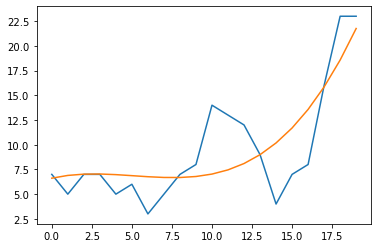

In [14]:
plt.plot(y)
plt.plot(y_.detach().numpy())
plt.show()

## The Wine Dataset

For our Torch example we will use the Wine dataset which is conveniently available
in the sklearn package. Sadly, it is pitifully small. However, for our purpose
of illustrating the process this does not matter.

The dataset contains 13 columns of numerical values describing chemical properties
of wine. The target identifies one of 3 types of wine. 

By sklearn convention the 
target is encoded by numbered label which we will convert to one-hot notation.

We print a few data values as well as the number of observations in each target class 
which shows that the dataset is reasonably balanced.

In [15]:
from sklearn import datasets

ds = datasets.load_wine()
print('observations:', ds.data.shape)
print(ds.data)
print('targets:', ds.target.shape)
print(ds.target)
print([ sum([t==c for t in ds.target]) for c in set(ds.target)])

observations: (178, 13)
[[  14.23    1.71    2.43 ...    1.04    3.92 1065.  ]
 [  13.2     1.78    2.14 ...    1.05    3.4  1050.  ]
 [  13.16    2.36    2.67 ...    1.03    3.17 1185.  ]
 ...
 [  13.27    4.28    2.26 ...    0.59    1.56  835.  ]
 [  13.17    2.59    2.37 ...    0.6     1.62  840.  ]
 [  14.13    4.1     2.74 ...    0.61    1.6   560.  ]]
targets: (178,)
[0 0 0 ... 2 2 2]
[59, 71, 48]


To explore possible clusters we scatter-plot the first two columns: a tentative first step.

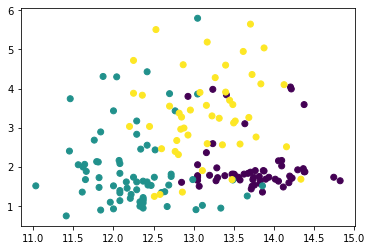

In [16]:
plt.scatter(ds.data[:,0], ds.data[:,1], c=ds.target)

Going to principal components we can get a better idea about 
structure in the dataset [11]:

StandardScaler:
[[ 1.5186 -0.5622  0.2321 ...  0.3622  1.8479  1.013 ]
 [ 0.2463 -0.4994 -0.828  ...  0.4061  1.1134  0.9652]
 [ 0.1969  0.0212  1.1093 ...  0.3183  0.7886  1.3951]
 ...
 [ 0.3328  1.7447 -0.3894 ... -1.6121 -1.4854  0.2806]
 [ 0.2092  0.2277  0.0127 ... -1.5683 -1.4007  0.2965]
 [ 1.3951  1.5832  1.3652 ... -1.5244 -1.4289 -0.5952]]
PCA:
[[ 3.3168 -1.4435]
 [ 2.2095  0.3334]
 [ 2.5167 -1.0312]
 ...
 [-2.6778 -2.7609]
 [-2.387  -2.2973]
 [-3.2088 -2.7689]]


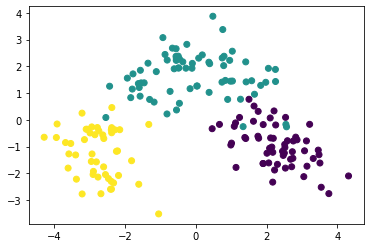

In [17]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

x = ds.data
x = StandardScaler().fit_transform(x)
print('StandardScaler:')
print(x)
x = PCA(n_components=2).fit_transform(x)
print('PCA:')
print(x)
plt.scatter(x[:,0], x[:,1], c=ds.target)

Sklearn uses numbered labels for classification targets while our neural net implementation
will use one-hot encoding; np.eye() and np.argmax() help with the transformations.

In [18]:
l = [2, 1, 0, 1, 2, 1] # numbered labels
h = np.eye(max(l)+1)[l] # one-hot
print(h)
print(np.argmax(h, axis=1)) # back to labels

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[2 1 0 1 2 1]


#### Feature Scaling and Train-Test Split

Connectionist machine learning methods tend to work best with some
sort of feature scaling. A common method is standardizing data: 
center around the mean and scale to multiples of standard
deviations. This is especially important 
when there are differences in order of magnitude among attributes,
such as in the Wine dataset; without standardizing it would be much more
difficult for optimization by gradient descent to find a near-optimal 
solution.

We apply the scaling after the train-test split, and using only information
from the training set; otherwise
information from the test set would be available for training (data leakage).

In [19]:
from sklearn.model_selection import train_test_split

def stan(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# from numbered labels to one-hot
Y = np.eye(max(ds.target)+1)[ds.target]

# common splits: 70/30, 80/20 
X_train, X_test, Y_train, Y_test = train_test_split(ds.data, Y, 
                                                    test_size=0.3, 
                                                    random_state=13)
mu = np.mean(X_train, axis=0)
sd = np.std(X_train, axis=0)

X_train, X_test = (X_train - mu) / sd, (X_test - mu) / sd

print('X_train:', type(X_train), X_train.shape)
print(X_train)
print('Y_train:', type(Y_train), Y_train.shape)
print(Y_train)
print('observations per class in training set:', np.sum(Y_train, axis=0))
print('                         ..in test set:', np.sum(Y_test, axis=0))

X_train: <class 'numpy.ndarray'> (124, 13)
[[ 1.3515  1.5629  1.3043 ... -1.5075 -1.403  -0.5938]
 [-1.7781 -0.2945  3.0192 ... -0.1027  1.5342 -0.9063]
 [ 1.6559 -0.4576  0.0443 ...  1.0827  0.5645  2.6537]
 ...
 [-1.291  -1.1643 -0.2357 ...  0.1607  0.7472  0.4789]
 [ 0.1825  0.1948  0.0093 ... -1.5514 -1.3749  0.3275]
 [-1.1449 -1.128   0.4993 ...  1.5656  0.171  -0.3634]]
Y_train: <class 'numpy.ndarray'> (124, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
observations per class in training set: [41. 48. 35.]
                         ..in test set: [18. 23. 13.]


Our implementation makes the forward pass explicit; for the 
error backpropagation and optimization we rely on Torch.

- Each operation on a Torch tensor is associated with a gradient. 
- We define our trainable parameters as tensors which require such a gradient.
- Torch will then create the computation graph leading to the loss. 
- This allows the optimizer to work on the
parameter values and hopefully minimize the loss. 

However, in realistic applications the search space in the possible parameter values 
is huge, and any optimum we find will most likely be a local one.

In [20]:
import torch as t
import numpy as np

class NN:
    
    def fwd(my, x):
        zj = t.matmul(x, my.Wj) + my.bj
        aj = 1 / (1 + t.exp(-zj))
        zk = t.matmul(aj, my.Wk) + my.bk
        return 1 / (1 + t.exp(-zk))
    
    def addones(my, X):
        return t.from_numpy(np.append(X, np.ones((X.shape[0], 1)), axis=1)).float() 
    
    def predict(my, X):
        x = t.from_numpy(X).float()     
        return my.fwd(x)
    
    def acc(my, y, y_pred):
        yp = y_pred.detach().numpy()
        return sum([np.argmax(y[i])==np.argmax(yp[i]) for i in range(len(y))])/len(y)
    
    def train(my, X, Y, h=30, lr=0.1, eps=30):
        my.Wj = t.rand(X.shape[1], h, dtype=t.float, requires_grad=True)
        my.bj = t.rand(h,             dtype=t.float, requires_grad=True)
        my.Wk = t.rand(h, Y.shape[1], dtype=t.float, requires_grad=True)
        my.bk = t.rand(Y.shape[1],    dtype=t.float, requires_grad=True)
        x = t.from_numpy(X).float() 
        y = t.from_numpy(Y).float()
        opti = t.optim.Adam([my.Wj, my.bj, my.Wk, my.bk], lr)
        for ep in range(eps):
            y_pred = my.fwd(x)
            err = y_pred - y
            loss = err.pow(2).sum() / X.shape[0]
            opti.zero_grad()
            loss.backward()
            opti.step()
            if (ep % (eps/10)) == 0: 
                print('loss: %5.3f' % float(loss.item()),
                      ' train.acc: %4.2f' % my.acc(y, y_pred),
                      ' y_pred[0]:', y_pred[0].detach().numpy())
            
nn = NN()
nn.train(X_train, Y_train)
Y_pred = nn.predict(X_test)
print('test acc: %4.2f' % nn.acc(Y_test, Y_pred))

loss: 1.880  train.acc: 0.24  y_pred[0]: [1. 1. 1.]
loss: 1.403  train.acc: 0.27  y_pred[0]: [0.938  0.7605 0.9948]
loss: 0.617  train.acc: 0.48  y_pred[0]: [0.1378 0.0112 0.7643]
loss: 0.384  train.acc: 0.78  y_pred[0]: [0.4434 0.0012 0.2851]
loss: 0.251  train.acc: 0.87  y_pred[0]: [0.6314 0.0005 0.3748]
loss: 0.107  train.acc: 0.96  y_pred[0]: [0.355  0.0008 0.74  ]
loss: 0.073  train.acc: 0.97  y_pred[0]: [0.1281 0.0016 0.9228]
loss: 0.050  train.acc: 0.98  y_pred[0]: [0.0734 0.0024 0.9731]
loss: 0.024  train.acc: 0.99  y_pred[0]: [0.0536 0.0037 0.9894]
loss: 0.021  train.acc: 0.99  y_pred[0]: [0.0381 0.005  0.9946]
test acc: 0.96


To compare the results with the sklearn implementation MLPClassifier
we need to transform our one-hot encoded classes to numbered labels with np.argmax().
Note that with such a small dataset the results are very much dependent on the
random seed.

In [21]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(30,), 
                    random_state=13,
                    max_iter=100).fit(X_train, np.argmax(Y_train, axis=1))
print('test acc: %4.2f' % clf.score(X_test, np.argmax(Y_test, axis=1)))

test acc: 0.94


/home/hugo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### Building Torch Models

We do not have to code our model in pure Python as above; 
Torch provides a large number of building blocks for connectionist models.
By using these blocks we can modify and extend our model much more easily.
It also allows us to use a number of convenient utility functions, such as 
reporting and summarizing tools. [9]

The optimization works
in the same manner as above, except for the call to model.parameters() which
provides the list of tensors at the leaves of the computation graph. Each 
ready-made module adds its parameters to the list, and the complete collection
is the set of values the optimizer can use to minimize the loss.

In [22]:
import torch
torch.manual_seed(17)

class Sig2(torch.nn.Module):

    def __init__(self, in_dim, out_dim, hid_dim=30):
        super(Sig2, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, hid_dim)
        self.act1 = torch.nn.Sigmoid()
        self.lin2 = torch.nn.Linear(hid_dim, out_dim)
        self.act2 = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        return x
    
    def predict(my, x):
        x = t.from_numpy(x).float()     
        return my.forward(x)
    
    def acc(my, y, y_pred):
        yp = y_pred.detach().numpy()
        return sum([np.argmax(y[i])==np.argmax(yp[i]) for i in range(len(y))])/len(y)

    def train(my, x, y, eps=10):
        x = t.from_numpy(x).float() 
        y = t.from_numpy(y).float()
        opti = t.optim.Adam(my.parameters(), 0.1)
        for ep in range(eps):
            y_pred = my.forward(x)
            err = y_pred - y
            loss = err.pow(2).sum() / x.shape[0]
            opti.zero_grad()
            loss.backward()
            opti.step()
            print('loss: %5.3f' % float(loss.item()),
                  ' train.acc: %4.2f' % my.acc(y, y_pred),
                  ' y_pred[0]:', y_pred[0].detach().numpy())
    
model = Sig2(X_train.shape[1], Y_train.shape[1])

print('Model:')
print(model)

print('Number of trainable parameters:', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

print('Parameters:')
for param in model.parameters(): 
    print(param.shape)
    #print(param)
print('check number of elements:', 30 * 13 + 30 + 3 * 30 + 3, '\n')

model.train(X_train, Y_train)
Y_pred = model.predict(X_test)
print('test.acc: %4.2f' % model.acc(Y_test, Y_pred))

Model:
Sig2(
  (lin1): Linear(in_features=13, out_features=30, bias=True)
  (act1): Sigmoid()
  (lin2): Linear(in_features=30, out_features=3, bias=True)
  (act2): Sigmoid()
)
Number of trainable parameters: 513
Parameters:
torch.Size([30, 13])
torch.Size([30])
torch.Size([3, 30])
torch.Size([3])
check number of elements: 513 

loss: 0.734  train.acc: 0.35  y_pred[0]: [0.5214 0.5202 0.382 ]
loss: 0.677  train.acc: 0.90  y_pred[0]: [0.1536 0.1181 0.1747]
loss: 0.588  train.acc: 0.94  y_pred[0]: [0.0902 0.1075 0.2914]
loss: 0.393  train.acc: 0.92  y_pred[0]: [0.0825 0.168  0.557 ]
loss: 0.272  train.acc: 0.94  y_pred[0]: [0.099  0.2507 0.8182]
loss: 0.229  train.acc: 0.96  y_pred[0]: [0.1318 0.2372 0.9232]
loss: 0.186  train.acc: 0.96  y_pred[0]: [0.1682 0.1519 0.9565]
loss: 0.137  train.acc: 0.97  y_pred[0]: [0.1908 0.0756 0.9679]
loss: 0.094  train.acc: 0.98  y_pred[0]: [0.1916 0.0348 0.9713]
loss: 0.061  train.acc: 0.98  y_pred[0]: [0.1747 0.0165 0.971 ]
test.acc: 0.96


##  Synthetic Data

Although there is a huge amount of open data available freely it is often
challenging to find datasets of high quality for a particular purpose.
However, we can always
generate our own data. Synthetic data has some advantages over real data:
- we can make it exactly the way we want: size, number of attributes, range of values, ..
- no restrictions because of copyright, privacy, or other legal problems
- no problems with unusual formats, missing values, and tricky import routines

Here is a simple approach to generate data for testing a classification algorithm:

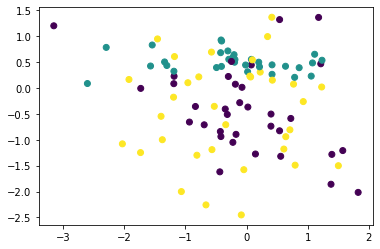

In [23]:
import sklearn.datasets as dt

x,y = dt.make_classification(n_samples=100,
                             n_classes=3,
                             n_clusters_per_class=1,
                             n_features=4,
                             n_redundant=0,
                             class_sep=0.5,
                             random_state=13)
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

However, a completely synthetic dataset can only have the structure that we put 
into it. Often we would like to have synthetic data that is more 'real'.

#### Kernel Density Estimation

Another approach is to generate synthetic data based on
a real dataset using its statistical properties,
e.g. by kernel density estimation. An example in 1D illustrates the
idea [7]; given an input distribution the propability density function is estimated.
Additional samples can then be generated based on that estimation.

A kernel in this context is a positive function for estimating the propability
density.
The example uses a gaussian kernel which is also the default for KernelDensity(), 
but other kernels are available and may result in a better fit.

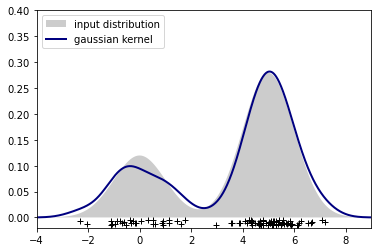

In [24]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

N = 100
np.random.seed(1)
X_syn = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")

kde = KernelDensity(kernel='gaussian', bandwidth=0.6).fit(X_syn)
log_dens = kde.score_samples(X_plot)
ax.plot(X_plot[:, 0], np.exp(log_dens),
    color="navy", lw=2, linestyle="-", label="gaussian kernel")

ax.legend(loc="upper left")
ax.plot(X_syn[:, 0], -0.005 - 0.01 * np.random.random(X_syn.shape[0]), "+k")
ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

The bandwidth parameter determines the fit and smoothness of the result.

In the Wine dataset the values
of the various attributes differ by 3 orders of magnitude,
and the choice of bandwidth is difficult. 

In [25]:
np.set_printoptions(suppress=True, precision=3, threshold=20)

print('means:\n', np.mean(ds.data, axis=0))

means:
 [ 13.001   2.336   2.367  19.495  99.742   2.295   2.029   0.362   1.591
   5.058   0.957   2.612 746.893]


To get some idea of how well this approach works we scatter-plot two attributes 
together with an equal amount of generated samples:

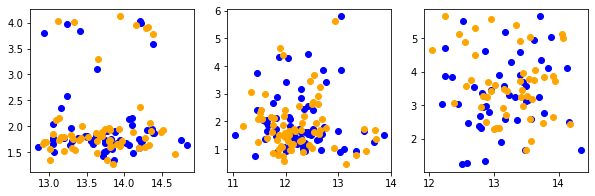

In [26]:
def plotsamp(ds, func):
    i, j = 0, 1
    fig, ax = plt.subplots(nrows=1, ncols=3)
    for t in set(ds.target):
        dat = ds.data[ds.target==t]
        syn = func(ds, t)
        ax[t].scatter(dat[:,i], dat[:,j], c='blue')
        ax[t].scatter(syn[:,i], syn[:,j], c='orange')
    fig.set_size_inches(10, 3)

def skdens(ds, t):
    dat = ds.data[ds.target==t]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dat)
    return kde.sample(len(dat))

plotsamp(ds, skdens)

There is another easily available implementation of kernel density estimation
in SciPy [10] which may give better results, depending on the dataset:

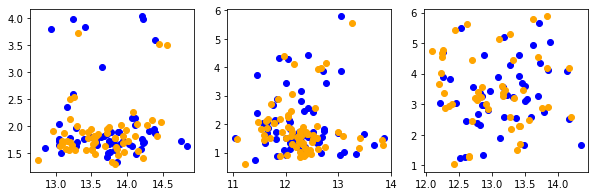

In [27]:
from scipy import stats

def scdens(ds, t):
    dat = ds.data[ds.target==t]
    kde = stats.gaussian_kde(dat.T, bw_method=0.2)
    return kde.resample(len(dat)).T

plotsamp(ds, scdens)

#### Minority Class Over-Sampling

Data augmentation by adding synthetic samples (instead of simply duplicating existing
samples) 
can help in preventing overfitting. Competition winning classifiers have used techniques to increase the number
of training samples [8]. 

Augmenting a classification dataset is also an option when
the classes are not balanced. 
A popular method to increase the number of
training samples in the minority class by over-sampling is SMOTE 
(Synthetic Minority Over-sampling Technique) [4] which uses
an approach based on nearest neighbors in feature space:

- randomly select a member from the minority class
- randomly select one of the k nearest members of the same class
- interpolate to random points between feature values

Note that the algorithm does not directly model the distribution of the original samples.
A Python implementation is available in the imblearn package [5]. Although primarily
intended as a minority over-sampling method, SMOTE can
also be used to increase the number of samples in all classes.

In [28]:
# !pip install imblearn   # version problem with sklearn, may need kernel restart

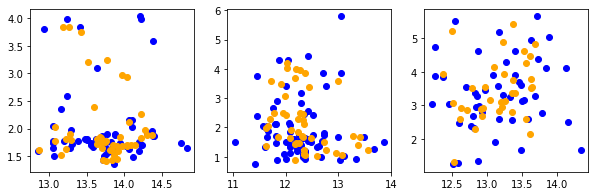

In [29]:
from imblearn.over_sampling import SMOTE

def smot(ds, t):
    strat = {}
    for x in set(ds.target): strat[x] = 2*len(ds.target[ds.target==x])
    sm = SMOTE(sampling_strategy=strat)
    X_res, y_res = sm.fit_resample(ds.data, ds.target)
    return np.asarray([ X_res[ix] for ix, pt in enumerate(X_res) 
            if (pt not in ds.data) and (y_res[ix]==t) ])

plotsamp(ds, smot)

Synthetic data is an interesting and increasingly relevant area; here, we have only 
scratched the surface.

## Notes

[1]  http://neuralnetworksanddeeplearning.com/chap4.html

[2] https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

[3] The data was generated by the following statements; however, those are not
involved in the Torch optimization.

    f = lambda x: 0.2 + 0.4 * x**2 + 0.3 * x * np.sin(15 * x) + 0.05 * np.cos(50 * x)
    y = [ int(f(x)*30) for x in np.arange(0,1,0.05) ]

[4] https://arxiv.org/abs/1106.1813

[5] https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html

[6] https://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html

[7] https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

[8] https://arxiv.org/pdf/1609.08764.pdf

[9] https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

[10] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

[11] https://scikit-learn.org/stable/modules/decomposition.html#pca

[12] https://www.geeksforgeeks.org/running-python-script-on-gpu/

[13] https://www.gabriel.urdhr.fr/2022/08/28/trying-to-run-stable-diffusion-on-amd-ryzen-5-5600g/

Johann Mitloehner, 2023

### Surplus Code

Things that might come in handy for your own projects.


#### Grid Search

An option e.g. for kernel density bandwidth selection when all attributes 
are in the same value range.

In [30]:
from sklearn.model_selection import GridSearchCV

def skdegrid(ds, t):
    params = {'bandwidth': np.arange(0.1, 10, 0.1)}
    grid = GridSearchCV(KernelDensity(), params)
    dat = ds.data[ds.target==t]
    grid.fit(dat)
    kde = grid.best_estimator_
    print('target', t, 'bandwidth: %.3f' % grid.best_params_['bandwidth'])
    return kde.sample(3)

i = [1,2,5,6,11]
print('means:')
print(np.mean(ds.data[:,i], axis=0))

from sklearn.utils import Bunch

d = Bunch(data=ds.data, target=ds.target)
d.data = d.data[:,i]
for t in set(d.target):
    print(skdegrid(d, t))

means:
[2.336 2.367 2.295 2.029 2.612]
target 0 bandwidth: 0.200
[[1.733 2.94  3.123 3.188 2.841]
 [1.833 2.571 2.745 2.945 3.557]
 [2.069 2.708 2.88  3.113 2.831]]
target 1 bandwidth: 0.400
[[0.863 1.855 2.441 2.842 2.344]
 [2.087 2.278 3.427 4.666 2.884]
 [2.253 2.849 2.517 2.007 2.526]]
target 2 bandwidth: 0.300
[[ 4.591  2.315  1.782  0.842  1.631]
 [ 2.74   3.069  0.605 -0.175  2.104]
 [ 3.187  2.193  1.423  0.002  1.983]]
